In [2]:
# Using Drive as storage and github for version controll.

from google.colab import drive, userdata
import os

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Setup Paths (Change to your actual repo name)
REPO_PATH = "/content/drive/MyDrive/ML/DL_With_Pytorch"
%cd {REPO_PATH}

# 3. Secure Auth
token = userdata.get('GH_TOKEN')
username = "barada02"
repo = "DL_With_Pytorch"
!git remote set-url origin https://{token}@github.com/{username}/{repo}.git

# 4. Identity
!git config --global user.email "Chandanbarada2@gmail.com"
!git config --global user.name "Kumar"

!git pull origin main
print("✅ Environment Ready!")

Mounted at /content/drive
/content/drive/MyDrive/ML/DL_With_Pytorch
From https://github.com/barada02/DL_With_Pytorch
 * branch            main       -> FETCH_HEAD
Already up to date.
✅ Environment Ready!


# Commit and push

In [9]:
# Push notebook changes to GitHub
# IMPORTANT: Press Ctrl+S (Save) before running this!
!git add .
!git commit -m "update"
!git push origin main

[main ee53c07] update
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite 02_Datasets_001.ipynb (94%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 48.28 KiB | 1.72 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/barada02/DL_With_Pytorch.git
   4d39618..ee53c07  main -> main


# Datasets and Data Loader

PyTorch provides two data primitives: ```torch.utils.data.DataLoader``` and ```torch.utils.data.Dataset``` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## loading Fashion-MNIST

We load the FashionMNIST Dataset with the following parameters:
* ```root``` is the path where the train/test data is stored,

* ```train``` specifies training or test dataset,

* ```download=True``` downloads the data from the internet if it’s not available at root.

* ```transform``` and ```target_transform``` specify the feature and label transformations

In [6]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### Iterating and Visualizing the Dataset
We can index Datasets manually like a list: training_data[index]. We use matplotlib to visualize some samples in our training data.

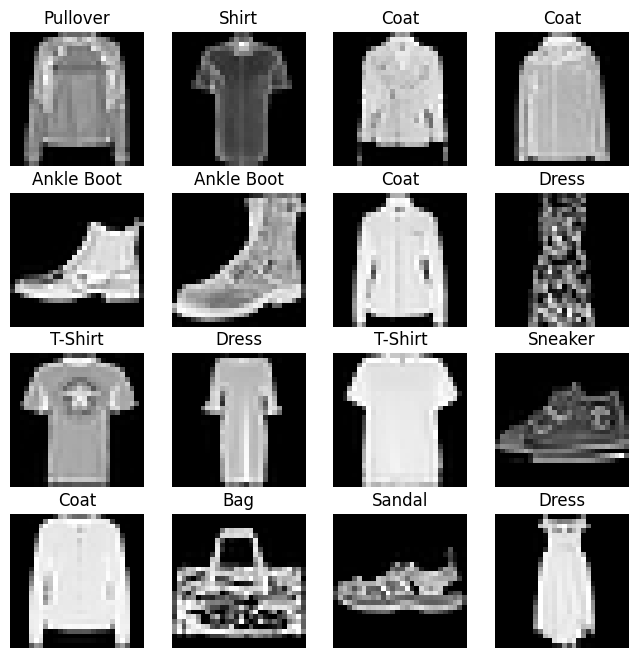

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files
A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory ```img_dir```, and their labels are stored separately in a CSV file ```annotations_file```.

In the next sections, we’ll break down what’s happening in each of these functions.

In [ ]:
import os
import pandas as pd
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


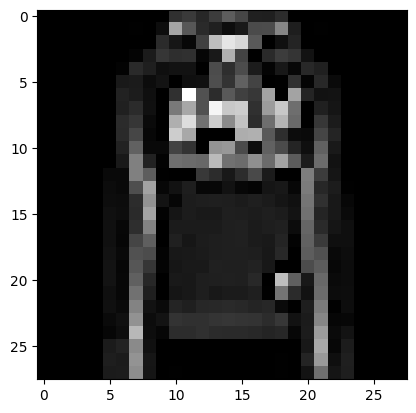

Label: 2


In [12]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Transforms

Data does not always come in its final processed form that is required for training machine learning algorithms. We use **transforms** to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -`transform` to modify the features and `target_transform` to modify the labels - that accept callables containing the transformation logic. The  [torchvision.transforms](https://docs.pytorch.org/vision/stable/transforms.html) module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use ToTensor and Lambda.

https://docs.pytorch.org/tutorials/beginner/basics/transforms_tutorial.html



In [14]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)